In [32]:
import pandas as pd
import datetime
import numpy as np
import torch
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Concatenate, Add, Masking, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MAE, MSE, RootMeanSquaredError


In [108]:
merged_df = pd.read_csv('merged_treated_tdfincl.csv', index_col=0)
merged_df.head()

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,ProfileScore:,Vert. meters:,Startlist quality score:,Won how:,adjusted_points,Race category:,Points scale:,Arrival:,Won how:,parcours_type_num
0,egan-bernal,2020,etappe,2020-09-16,0,NaN,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,444.0,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0
1,andrey-amador,2020,etappe,2020-09-16,117,79.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,444.0,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0
2,richard-carapaz,2020,etappe,2020-09-16,11,13.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,444.0,4430.0,1685.0,3.5 km solo,14962800.0,NaN,NaN,NaN,NaN,5.0
3,jonathan-castroviejo,2020,etappe,2020-09-16,116,40.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,444.0,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0
4,michal-kwiatkowski,2020,etappe,2020-09-16,130,37.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,444.0,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0


In [109]:
merged_df['key'] = merged_df['name'] + '-' + merged_df['year'].astype('str') + '-' + merged_df['race_name']
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df = merged_df[merged_df['year'] != 2022]
merged_df.head()

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,Vert. meters:,Startlist quality score:,Won how:,adjusted_points,Race category:,Points scale:,Arrival:,Won how:,parcours_type_num,key
0,egan-bernal,2020,etappe,2020-09-16,0,NaN,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0,egan-bernal-2020-tour-de-france
1,andrey-amador,2020,etappe,2020-09-16,117,79.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0,andrey-amador-2020-tour-de-france
2,richard-carapaz,2020,etappe,2020-09-16,11,13.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,14962800.0,NaN,NaN,NaN,NaN,5.0,richard-carapaz-2020-tour-de-france
3,jonathan-castroviejo,2020,etappe,2020-09-16,116,40.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0,jonathan-castroviejo-2020-tour-de-france
4,michal-kwiatkowski,2020,etappe,2020-09-16,130,37.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0,michal-kwiatkowski-2020-tour-de-france


In [110]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

minmax_features = MinMaxScaler()

minmax_features.fit(merged_df[['distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']])

merged_df[['distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']] = minmax_features.transform(merged_df[['distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']])

minmax_target= MinMaxScaler()

minmax_target.fit(merged_df[['result']])

merged_df[['result']] = minmax_target.transform(merged_df[['result']])

merged_df.head()

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,Vert. meters:,Startlist quality score:,Won how:,adjusted_points,Race category:,Points scale:,Arrival:,Won how:,parcours_type_num,key
0,egan-bernal,2020,etappe,2020-09-16,0.000000,NaN,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,0.638421,0.929912,3.5 km solo,0.0,NaN,NaN,NaN,NaN,1.0,egan-bernal-2020-tour-de-france
1,andrey-amador,2020,etappe,2020-09-16,0.116302,79.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,0.638421,0.929912,3.5 km solo,0.0,NaN,NaN,NaN,NaN,1.0,andrey-amador-2020-tour-de-france
2,richard-carapaz,2020,etappe,2020-09-16,0.010934,13.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,0.638421,0.929912,3.5 km solo,14962800.0,NaN,NaN,NaN,NaN,1.0,richard-carapaz-2020-tour-de-france
3,jonathan-castroviejo,2020,etappe,2020-09-16,0.115308,40.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,0.638421,0.929912,3.5 km solo,0.0,NaN,NaN,NaN,NaN,1.0,jonathan-castroviejo-2020-tour-de-france
4,michal-kwiatkowski,2020,etappe,2020-09-16,0.129225,37.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,0.638421,0.929912,3.5 km solo,0.0,NaN,NaN,NaN,NaN,1.0,michal-kwiatkowski-2020-tour-de-france


In [60]:
riders = merged_df[(merged_df['race_name']=='tour-de-france')| (merged_df['race_name']=='vuelta-a-espana')| (merged_df['race_name']=='giro-d-italia')][['name', 'year', 'race_name']]
riders = riders[riders['year'] != 2022].drop_duplicates().reset_index(drop=True)
riders

,name,year,race_name
0,egan-bernal,2020,tour-de-france
1,andrey-amador,2020,tour-de-france
2,richard-carapaz,2020,tour-de-france
3,jonathan-castroviejo,2020,tour-de-france
4,michal-kwiatkowski,2020,tour-de-france
...,...,...,...
6528,bernhard-eisel,2010,vuelta-a-espana
6529,john-lee-augustyn,2010,vuelta-a-espana
6530,ben-swift,2010,vuelta-a-espana
6531,mickael-buffaz,2010,vuelta-a-espana


In [61]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(riders, test_size=0.2, random_state=42)

In [62]:
def get_sequence(df, name, year, tour, weeks=52):
    
    #get tour data
    if year != 2010:
        tour_data = df[(df['name'] == name) & (df['year'] == year) & (df['race_name'] == tour)].sort_values(by='date')
        y = tour_data[['date', 'result']].set_index('date')
        X_decoder = tour_data[['date', 'distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']].set_index('date')
        
        season_data = df[(df['name'] == name) & (df['date'] < min(tour_data['date'])) & (df['date'] >= min(tour_data['date']) - datetime.timedelta(weeks=weeks))].sort_values(by='date')
        X_encoder = season_data[['date', 'result', 'distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']].set_index('date')
        
    return X_encoder, X_decoder, y

In [63]:
from keras.preprocessing.sequence import pad_sequences

def get_sequences(maxlen, df, riders):
    
    X_encoder_ls = []
    X_decoder_ls = []
    y_ls = []

    for rider, year, tour in riders.values:
        
        if year != 2010:
            
            X_encoder, X_decoder, y = get_sequence(df, rider, year, tour)
            
            X_encoder = pad_sequences(X_encoder.to_numpy().T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
            X_decoder = pad_sequences(X_decoder.to_numpy().T, maxlen=21, dtype='float', padding='post', value=-1000.).T
            X_decoder = pad_sequences(X_decoder.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
            
            y = pad_sequences(y.to_numpy().T, maxlen=21, dtype='float', padding='post', value=-1000.).T
            y = pad_sequences(y.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                
            X_encoder_ls.append(X_encoder)
            X_decoder_ls.append(X_decoder)
            y_ls.append(y)
            
            print(rider, year, X_encoder.shape, X_decoder.shape, y.shape)
    
    return np.array(X_encoder_ls), np.array(X_decoder_ls), np.array(y_ls)


In [64]:
X_encoder_train, X_decoder_train, y_train = get_sequences(70, merged_df, train)
X_encoder_test, X_decoder_test, y_test = get_sequences(70, merged_df, test)

elie-gesbert 2019 (70, 6) (70, 5) (70, 1)
jose-joaquin-rojas 2012 (70, 6) (70, 5) (70, 1)
benoit-cosnefroy 2021 (70, 6) (70, 5) (70, 1)
matthew-goss 2013 (70, 6) (70, 5) (70, 1)
ruben-plaza 2016 (70, 6) (70, 5) (70, 1)
christian-knees 2013 (70, 6) (70, 5) (70, 1)
pierre-latour 2017 (70, 6) (70, 5) (70, 1)
pierre-rolland 2017 (70, 6) (70, 5) (70, 1)
johan-le-bon 2013 (70, 6) (70, 5) (70, 1)
murilo-antonio-fischer 2015 (70, 6) (70, 5) (70, 1)
ivan-velasco 2012 (70, 6) (70, 5) (70, 1)
jurgen-roelandts 2016 (70, 6) (70, 5) (70, 1)
andrey-amador 2013 (70, 6) (70, 5) (70, 1)
sergey-lagutin 2011 (70, 6) (70, 5) (70, 1)
koen-de-kort 2011 (70, 6) (70, 5) (70, 1)
christophe-laporte 2020 (70, 6) (70, 5) (70, 1)
giovanni-visconti 2017 (70, 6) (70, 5) (70, 1)
dmitriy-gruzdev 2021 (70, 6) (70, 5) (70, 1)
michael-kolar 2017 (70, 6) (70, 5) (70, 1)
mario-costa 2016 (70, 6) (70, 5) (70, 1)
juan-sebastian-molano 2019 (70, 6) (70, 5) (70, 1)
jose-joaquin-rojas 2020 (70, 6) (70, 5) (70, 1)
antwan-tolhoek 

In [68]:
# define the encoder and decoder
def encoder(encoder_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    y = LSTM(units=100, return_sequences=True, activation='tanh')(y)
    y = GRU(units=50, return_sequences=True, activation='tanh')(y)
    y = TimeDistributed(Dense(units=1))(y)
    return y

def decoder(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = -1000.)(x)
    y = TimeDistributed(Dense(units=100, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1))(y)
    return y

In [69]:
# build the model
encoder_features = Input(shape=X_encoder_train.shape[1:])
decoder_features = Input(shape=X_decoder_train.shape[1:])
encoder_outputs = encoder(encoder_features)
decoder_outputs = decoder(decoder_features, encoder_outputs)
model = Model([encoder_features, decoder_features], decoder_outputs)

In [70]:
# train the model
metric = RootMeanSquaredError()

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mae', metrics=[metric])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=8, restore_best_weights=True)

model.fit([X_encoder_train, X_decoder_train], y_train, epochs=100, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

Epoch 1/100
27/27 [==============================] - 9s 162ms/step - loss: 99.4683 - root_mean_squared_error: 199.8371 - val_loss: 11.7234 - val_root_mean_squared_error: 13.7438
Epoch 2/100
27/27 [==============================] - 3s 100ms/step - loss: 14.5799 - root_mean_squared_error: 17.4216 - val_loss: 17.9640 - val_root_mean_squared_error: 21.0828
Epoch 3/100
27/27 [==============================] - 3s 101ms/step - loss: 14.6253 - root_mean_squared_error: 17.7817 - val_loss: 11.2660 - val_root_mean_squared_error: 13.2194
Epoch 4/100
27/27 [==============================] - 3s 100ms/step - loss: 14.7097 - root_mean_squared_error: 17.9991 - val_loss: 19.1562 - val_root_mean_squared_error: 22.4803
Epoch 5/100
27/27 [==============================] - 3s 102ms/step - loss: 14.9793 - root_mean_squared_error: 18.3864 - val_loss: 10.4478 - val_root_mean_squared_error: 12.2546
Epoch 6/100
27/27 [==============================] - 3s 102ms/step - loss: 15.3318 - root_mean_squared_error: 18.7

In [71]:
model.evaluate([X_encoder_test, X_decoder_test], y_test)

38/38 [==============================] - 1s 17ms/step - loss: 0.2407 - root_mean_squared_error: 0.3225


[0.24073396623134613, 0.3224868178367615]

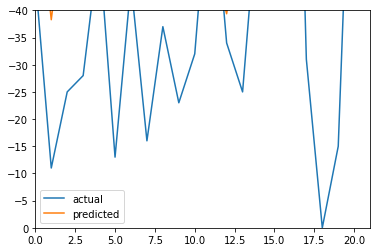

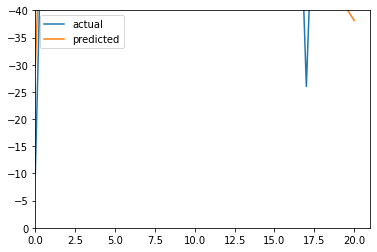

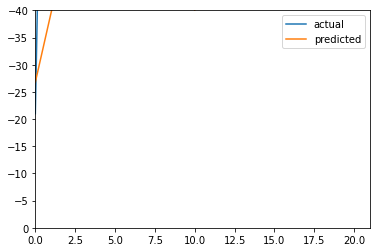

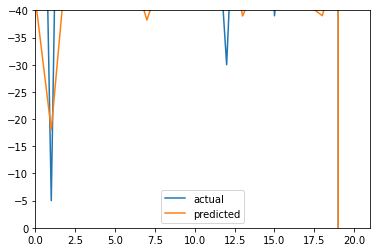

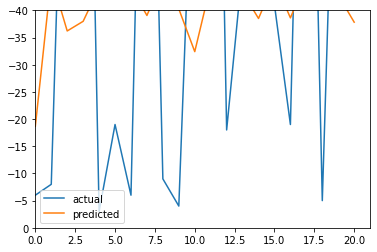

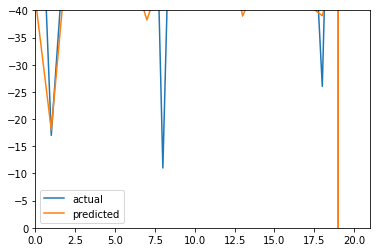

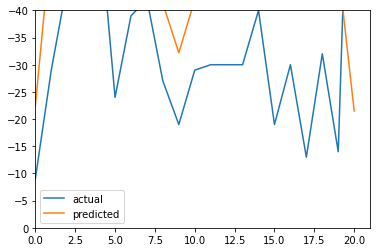

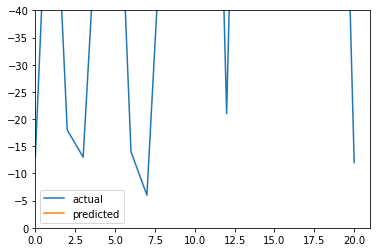

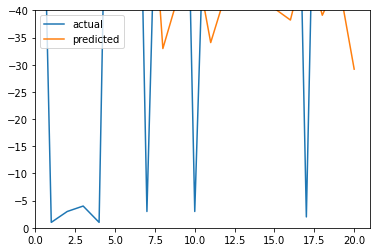

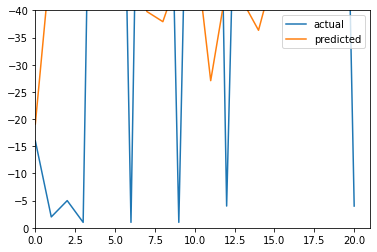

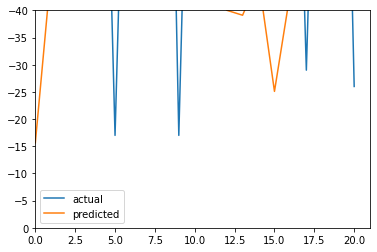

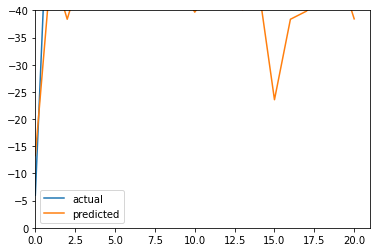

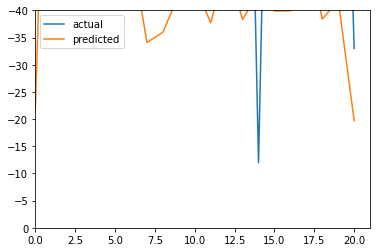

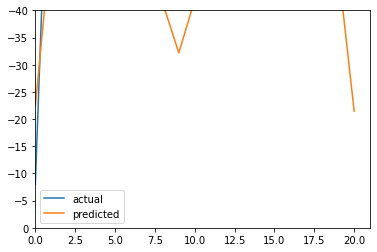

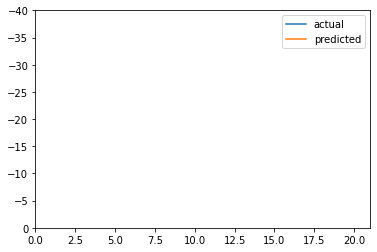

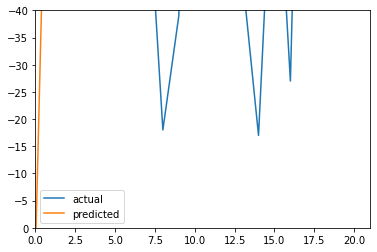

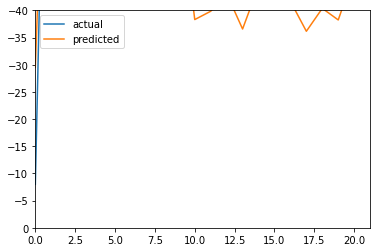

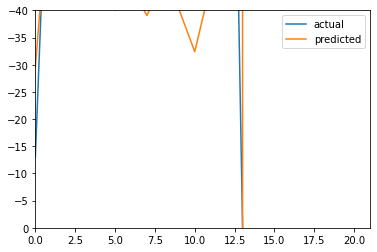

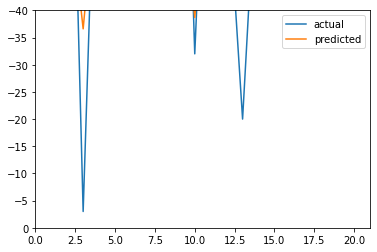

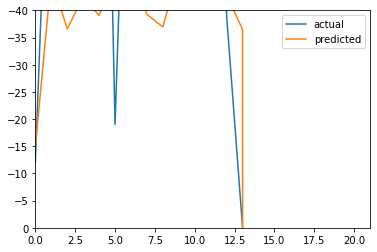

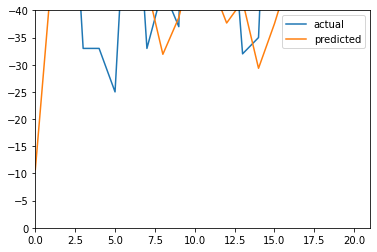

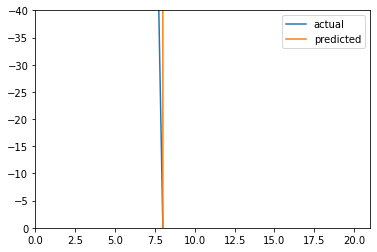

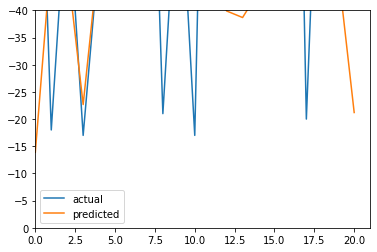

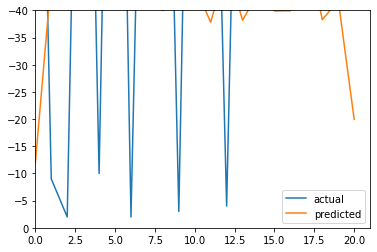

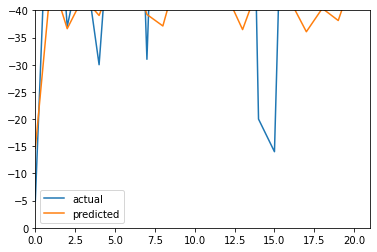

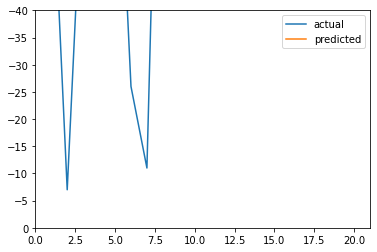

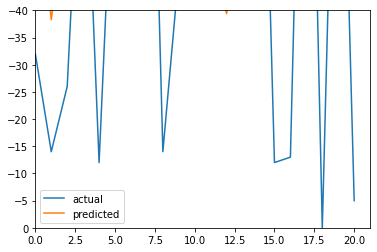

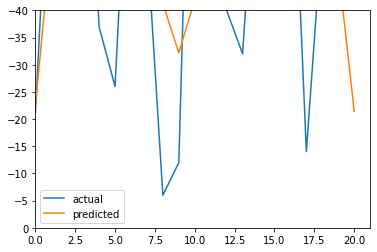

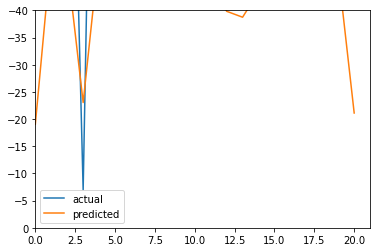

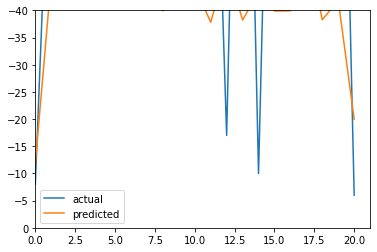

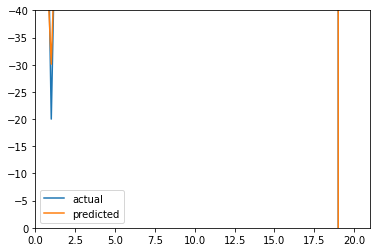

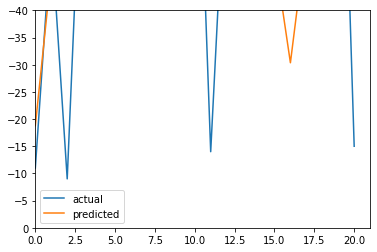

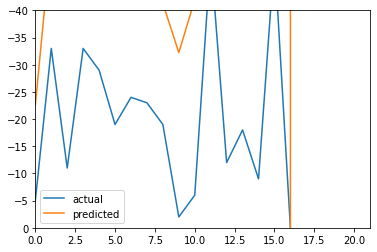

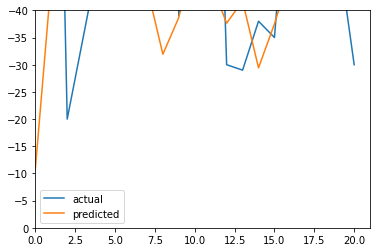

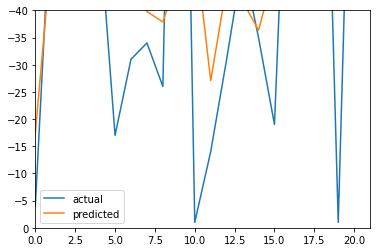

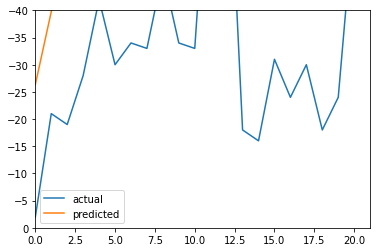

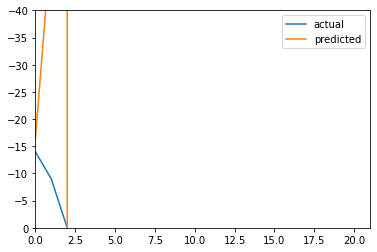

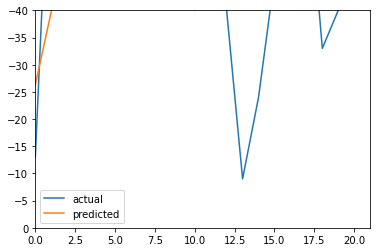

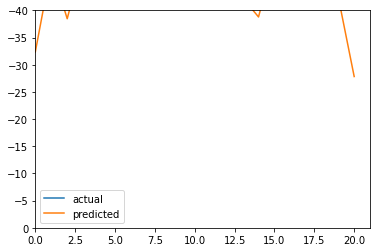

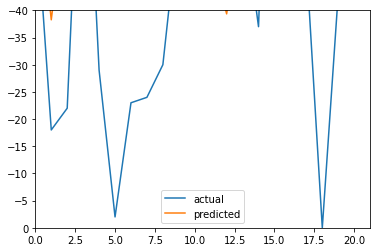

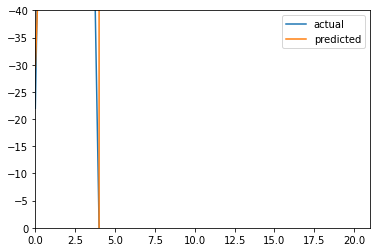

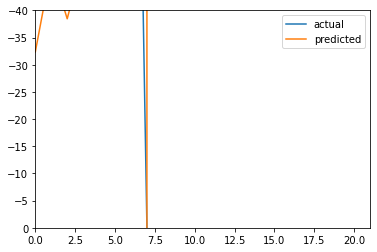

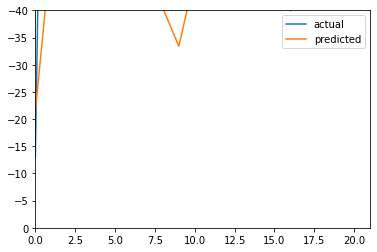

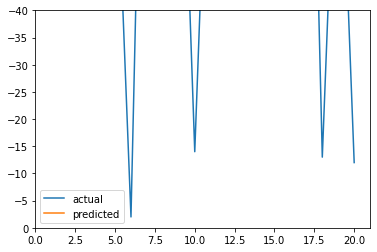

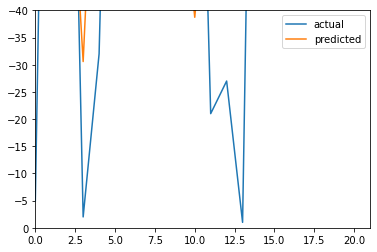

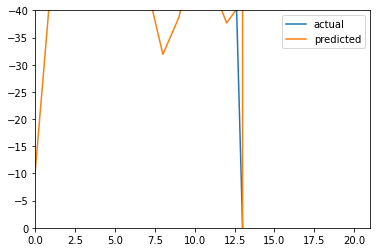

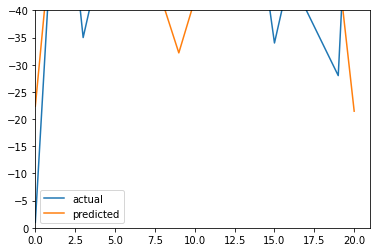

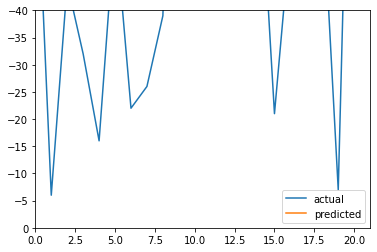

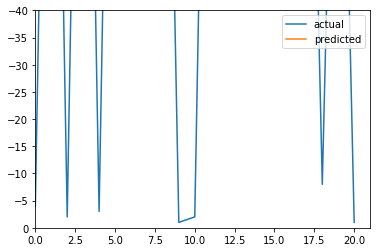

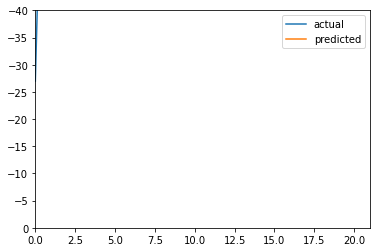

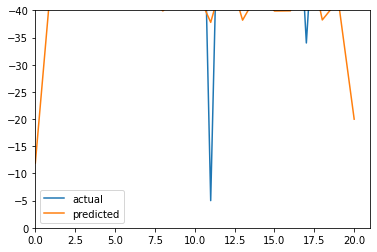

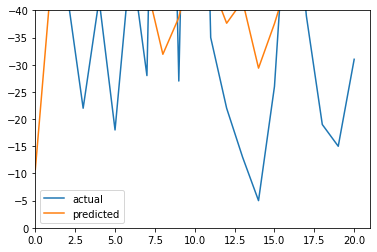

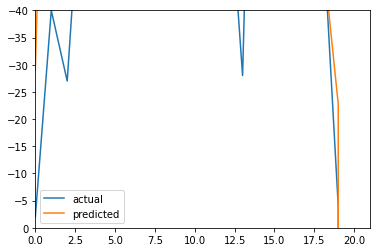

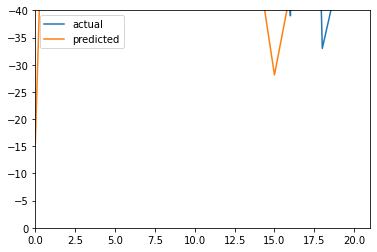

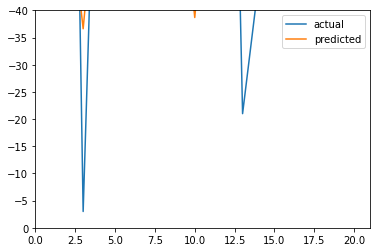

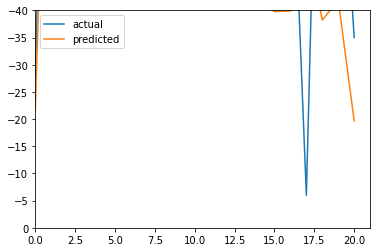

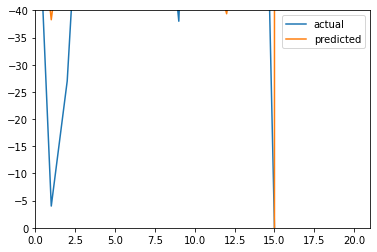

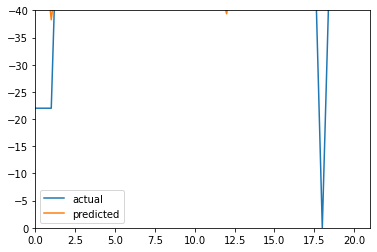

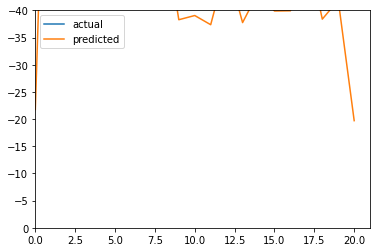

KeyboardInterrupt: 

In [121]:
# extract the last predicted sequence
for seq in range(20,100):

    y_true = minmax_target.inverse_transform(y_test[seq, :][-21:])*-1
    y_pred = minmax_target.inverse_transform(model.predict([X_encoder_test, X_decoder_test])[seq, :][-21:])*-1

    # plot the last predicted sequence
    #plt.title(list(test_name)[seq])
    plt.plot(y_true.flatten(), label='actual')
    plt.plot(y_pred.flatten(), label='predicted')
    plt.axis([0, 21, 0, -40])
    plt.legend()
    plt.show()

In [516]:
X_encoder = torch.load('torch_data/X_encoder_ls.pt') # past features and target values
X_decoder = torch.load('torch_data/X_decoder_ls.pt') # future features values
y = torch.load('torch_data/y_ls.pt') # future target values

X_encoder.shape, X_decoder.shape, y.shape

((6044, 70, 5), (6044, 70, 4), (6044, 70, 1))

In [613]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

riders_df = pd.read_csv('new_data/df_riders.csv')

train_name, test_name = train_test_split(riders_df['key'], test_size=0.20, random_state=42)

In [653]:
test_name = riders_df.loc[test].key

df_test = pd.DataFrame(test_name)

df_test.head()

,key
2505,merhawi-kudus-2016-giro-d-italia
4602,simon-clarke-2013-vuelta-a-espana
1992,eugenio-alafaci-2017-giro-d-italia
1918,lukasz-owsian-2017-giro-d-italia
4945,grega-bole-2013-giro-d-italia


In [536]:
#split train test


length = np.arange(0,X_encoder.shape[0],1)

train, test = train_test_split(length, test_size=0.20, random_state=42)

X_encoder_train = []
X_encoder_test = []
X_decoder_train = []
X_decoder_test = []

y_train = []
y_test = []

for i in train:
    X_encoder_train.append(X_encoder[i])
    X_decoder_train.append(X_decoder[i])
    y_train.append(y[i])
    
    
for i in test:
    X_encoder_test.append(X_encoder[i])
    X_decoder_test.append(X_decoder[i])
    y_test.append(y[i])
    
X_encoder_train = np.array(X_encoder_train)
X_encoder_test = np.array(X_encoder_test)
X_decoder_train = np.array(X_decoder_train)
X_decoder_test = np.array(X_decoder_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [693]:
# define the encoder and decoder
def encoder(encoder_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    y = LSTM(units=100, return_sequences=True, activation='tanh')(y)
    y = GRU(units=10, return_sequences=True, activation='tanh')(y)
    y = TimeDistributed(Dense(units=1))(y)
    return y

def decoder(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = -1000.)(x)
    y = TimeDistributed(Dense(units=100, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1))(y)
    return y

In [694]:
encoder_features

<KerasTensor: shape=(None, 70, 5) dtype=float32 (created by layer 'input_39')>

In [695]:
# build the model
encoder_features = Input(shape=X_encoder.shape[1:])
decoder_features = Input(shape=X_decoder.shape[1:])
encoder_outputs = encoder(encoder_features)
decoder_outputs = decoder(decoder_features, encoder_outputs)
model = Model([encoder_features, decoder_features], decoder_outputs)

In [696]:
# train the model
metric = RootMeanSquaredError()

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mae', metrics=[metric])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=8, restore_best_weights=True)

model.fit([X_encoder_train, X_decoder_train], y_train, epochs=100, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

Epoch 1/100
27/27 [==============================] - 9s 157ms/step - loss: 726.0260 - root_mean_squared_error: 851.4445 - val_loss: 725.8696 - val_root_mean_squared_error: 851.2188
Epoch 2/100
27/27 [==============================] - 2s 90ms/step - loss: 725.5623 - root_mean_squared_error: 850.8999 - val_loss: 725.4345 - val_root_mean_squared_error: 850.7097
Epoch 3/100
27/27 [==============================] - 2s 87ms/step - loss: 725.1315 - root_mean_squared_error: 850.3936 - val_loss: 725.0057 - val_root_mean_squared_error: 850.2046
Epoch 4/100
27/27 [==============================] - 2s 87ms/step - loss: 724.7015 - root_mean_squared_error: 849.8884 - val_loss: 724.5760 - val_root_mean_squared_error: 849.6992
Epoch 5/100
27/27 [==============================] - 2s 86ms/step - loss: 724.2718 - root_mean_squared_error: 849.3834 - val_loss: 724.1448 - val_root_mean_squared_error: 849.1938
Epoch 6/100
27/27 [==============================] - 2s 86ms/step - loss: 723.8419 - root_mean_squa

In [697]:
model.evaluate([X_encoder_test, X_decoder_test], y_test)

38/38 [==============================] - 1s 17ms/step - loss: 681.9053 - root_mean_squared_error: 800.4104


[681.9052734375, 800.410400390625]

In [565]:
model.save_weights('models/lstm_gru')

In [672]:
model.load_weights('models/lstm_gru')

In [610]:
model.predict([X_encoder_test, X_decoder_test])[1][-21:].sum()

36.54554

In [689]:
prediction_array = model.predict([X_encoder_test, X_decoder_test])

In [690]:
prediction_array.shape

(1209, 70, 21)

In [691]:
sum_ls = []
y_ls = []

for i in range(0, prediction_array.shape[0]):
    arr = prediction_array[i][-21:]
    arr = np.where(arr < -120, 0, arr)
    sum_ls.append(arr.sum())
    y_ls.append(y_test[i][-21:].sum())

In [692]:
prediction_array

array([[[-1.00063800e+03, -1.00453937e+03, -1.00186816e+03, ...,
         -1.00513770e+03, -1.00415717e+03, -1.00135309e+03],
        [-1.00063800e+03, -1.00453937e+03, -1.00186816e+03, ...,
         -1.00513770e+03, -1.00415717e+03, -1.00135309e+03],
        [-1.00063800e+03, -1.00453937e+03, -1.00186816e+03, ...,
         -1.00513770e+03, -1.00415717e+03, -1.00135309e+03],
        ...,
        [ 1.15328029e-01,  3.59018147e-03, -3.49273384e-01, ...,
         -4.71710742e-01,  4.48046625e-03,  3.69168818e-03],
        [ 1.18277535e-01,  6.55084848e-03, -3.46321642e-01, ...,
         -4.68749702e-01,  7.44001567e-03,  6.64296746e-03],
        [ 1.12960830e-01,  1.21401250e-03, -3.51642400e-01, ...,
         -4.74087209e-01,  2.10520625e-03,  1.32305920e-03]],

       [[-1.00063800e+03, -1.00453937e+03, -1.00186816e+03, ...,
         -1.00513770e+03, -1.00415717e+03, -1.00135309e+03],
        [-1.00063800e+03, -1.00453937e+03, -1.00186816e+03, ...,
         -1.00513770e+03, -1.00415717e

In [678]:
len(sum_ls)

1209

In [680]:
df_test = pd.DataFrame([test_name]).T
df_test['sum'] = sum_ls
df_test['y'] = y_ls

In [631]:
y_test

array([[[-1000.],
        [-1000.],
        [-1000.],
        ...,
        [    0.],
        [    0.],
        [    0.]],

       [[-1000.],
        [-1000.],
        [-1000.],
        ...,
        [    0.],
        [    0.],
        [    0.]],

       [[-1000.],
        [-1000.],
        [-1000.],
        ...,
        [    0.],
        [    0.],
        [    0.]],

       ...,

       [[-1000.],
        [-1000.],
        [-1000.],
        ...,
        [    0.],
        [    0.],
        [-1000.]],

       [[-1000.],
        [-1000.],
        [-1000.],
        ...,
        [    0.],
        [    0.],
        [    0.]],

       [[-1000.],
        [-1000.],
        [-1000.],
        ...,
        [    0.],
        [    0.],
        [    0.]]])

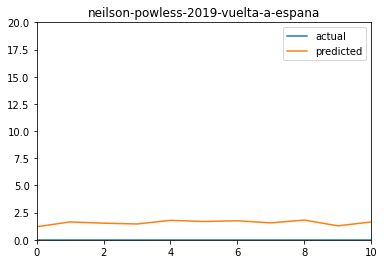

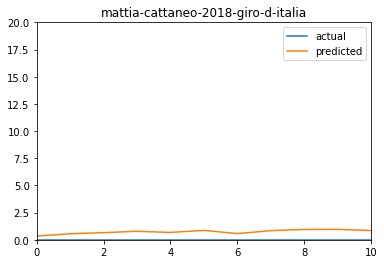

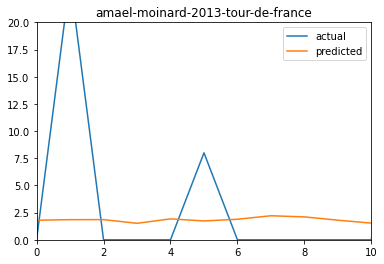

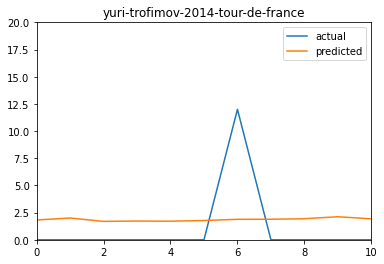

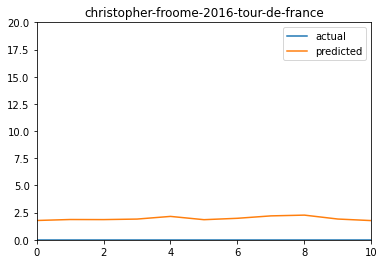

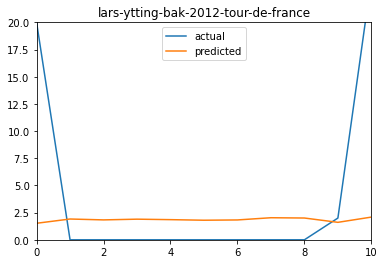

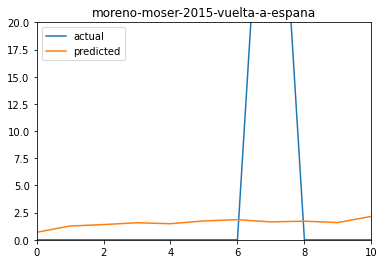

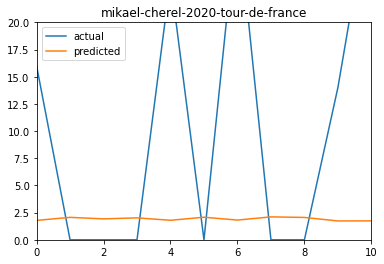

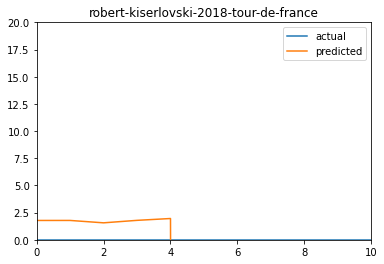

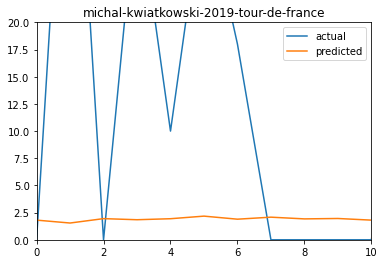

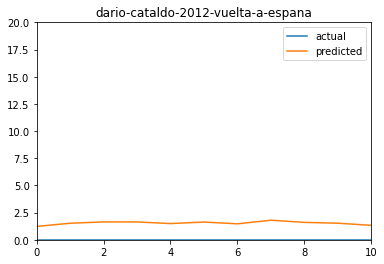

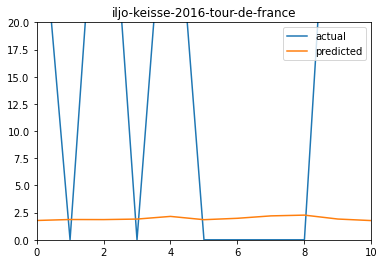

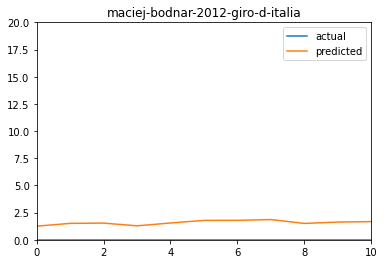

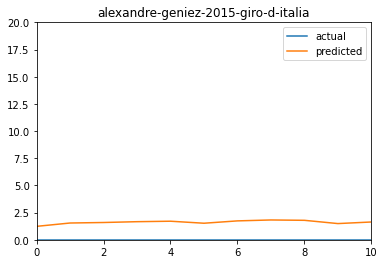

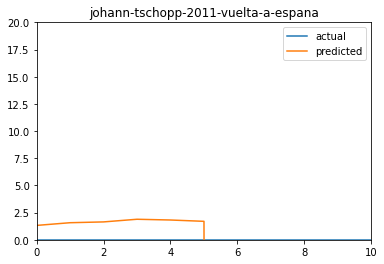

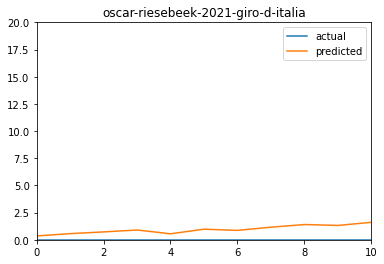

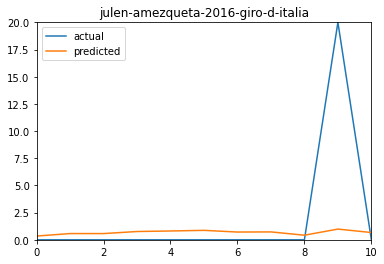

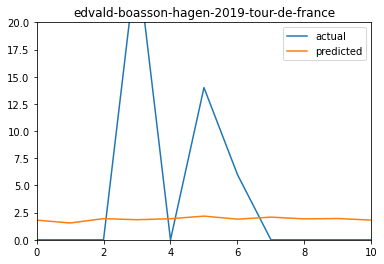

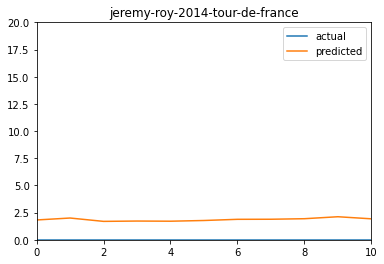

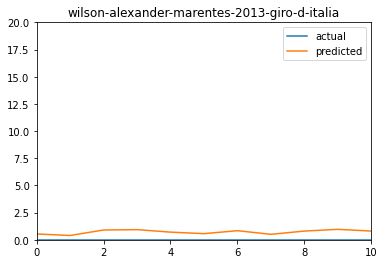

In [682]:
# extract the last predicted sequence
for seq in range(20,40):

    y_true = y[seq, :][-21:]
    y_pred = model.predict([X_encoder_test, X_decoder_test])[seq, :][-21:]

    # plot the last predicted sequence
    plt.title(list(test_name)[seq])
    plt.plot(y_true.flatten(), label='actual')
    plt.plot(y_pred.flatten(), label='predicted')
    plt.axis([0, 10, 0, 20])
    plt.legend()
    plt.show()

In [513]:
shuffled = np.arange(0,101,1)
np.random.shuffle(shuffled)
shuffled

array([ 95,  17,   2,  60,  28,  39,   0,  47,  52,   4,  26,  33,  58,
        67,  83,  63,  75,  88,  64,  71,  41,  84,  46,  44,  74,  59,
        65,  90,  53,   7,  80,  81,  15,  55,  89,  76,  77,  98,  22,
         1,  73,   5,  14,  78,  11,  43,  27,   3,  72,  86,  31,  61,
        16,  25,  85,  87,  19,  82,  48,  45,  35,  66,  50,  34,  10,
        62,  13,   6,  93,  79,  18,  40,  96,  92,  97,  30,  37,  57,
        51,  23, 100,  94,  42,  24,  56,  21,  32,  49,   9,  29,  36,
        20,  70,  99,  38,  91,  12,   8,  54,  68,  69])

In [373]:
X = torch.load('torch_data/X_full_scaled.pt')
y = torch.load('torch_data/y_full_scaled.pt')

In [374]:
X_tour = torch.load('torch_data/X_tour.pt')
y_tour = torch.load('torch_data/y_tour.pt')

In [418]:
X_tdf = torch.load('torch_data/X_tdf_2022.pt')
y_tdf = torch.load('torch_data/y_tdf_2022.pt')

X_tdf_tour = torch.load('torch_data/X_tour_tdf_2022.pt')
y_tdf_tour = torch.load('torch_data/y_tour_tdf_2022.pt')

In [417]:
y_tdf[0].shape

(62, 60)

In [428]:
X_tdf.shape, y_tdf.shape, X_tdf_tour.shape, y_tdf_tour.shape

((2210, 80, 4), (2210, 80, 1), (2210, 80, 4), (2210, 80, 1))

In [383]:
X_tour_pad = []
y_tour_pad = []

for xx in X_tour:
    X_tour_pad.append(pad_sequences(xx, maxlen=80, dtype='float', padding='pre', value=-1000.).T)
    
for yy in y_tour:
    y_tour_pad.append(pad_sequences(yy, maxlen=80, dtype='float', padding='pre', value=-1000.).T)
    
X_tour_pad = np.array(X_tour_pad)
y_tour_pad = np.array(y_tour_pad)

In [384]:
X_tour_pad.shape, y_tour_pad.shape

((38304, 80, 4), (38304, 80, 1))

In [385]:
X.shape, y.shape

((38304, 80, 4), (38304, 21, 1))

In [378]:
train_data_merged = []

for xx, yy in zip(X, y):
    train_data_merged.append(np.concatenate((xx, yy), axis=1))
    
train_data_merged = np.array(train_data_merged)

train_data_merged.shape

(38304, 80, 5)

In [429]:
train_data_merged_pred = []

for xx, yy in zip(X_tdf, y_tdf):
    train_data_merged_pred.append(np.concatenate((xx, yy), axis=1))
    
train_data_merged_pred = np.array(train_data_merged_pred)

train_data_merged_pred.shape

(2210, 80, 5)

In [358]:
# train the model
from tensorflow.keras.callbacks import EarlyStopping
metric = metrics.MAE

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[metric])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=2, restore_best_weights=True)

model.fit([X_encoder, X_decoder], y, epochs=100, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

In [426]:
X_encoder = train_data_merged  # past features and target values
X_decoder = X_tour_pad  # future features values
y = y_tour_pad          # future target values

X_encoder.shape, X_decoder.shape, y.shape

((38304, 80, 5), (38304, 80, 4), (38304, 80, 1))

In [430]:
X_encoder_pred = train_data_merged_pred  # past features and target values
X_decoder_pred = X_tdf_tour  # future features values
y_pred = y_tdf_tour

X_encoder_pred.shape, X_decoder_pred.shape, y_pred.shape

((2210, 80, 5), (2210, 80, 4), (2210, 80, 1))

In [459]:
X_tdf_tour[0][-21:]

array([[-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [ 4.01315789e-02,  3.79506641e-03,  3.02637268e-03,
         8.55408389e-01],
       [ 6.61842105e-01,  0.00000000e+00,  1.65585819e-01,
         8.55408389e-01],
       [ 5.95394737e-01,  9.48766603e-03,  1.84464620e-01,
         8.55408389e-01],
       [ 5.60855263e-01,  9.86717268e-02,  2.57241677e-01,
      

In [387]:
# define the encoder and decoder
def encoder(encoder_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    y = LSTM(units=100, return_sequences=True)(y)
    y = TimeDistributed(Dense(units=1))(y)
    return y

def decoder(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = -1000.)(x)
    y = TimeDistributed(Dense(units=100, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1))(y)
    return y

In [389]:
# build the model
encoder_features = Input(shape=X_encoder.shape[1:])
decoder_features = Input(shape=X_decoder.shape[1:])
encoder_outputs = encoder(encoder_features)
decoder_outputs = decoder(decoder_features, encoder_outputs)
model = Model([encoder_features, decoder_features], decoder_outputs)

In [394]:
# train the model
from tensorflow.keras.callbacks import EarlyStopping
metric = metrics.MAE

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[metric])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=2, restore_best_weights=True)

model.fit([X_encoder, X_decoder], y, epochs=100, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

Epoch 1/100
210/210 [==============================] - 19s 77ms/step - loss: 44.6760 - mean_absolute_error: 3.1075 - val_loss: 23.3128 - val_mean_absolute_error: 1.7873
Epoch 2/100
210/210 [==============================] - 15s 73ms/step - loss: 18.5712 - mean_absolute_error: 1.4276 - val_loss: 19.5045 - val_mean_absolute_error: 1.3631
Epoch 3/100
210/210 [==============================] - 15s 73ms/step - loss: 17.1064 - mean_absolute_error: 1.3262 - val_loss: 18.8654 - val_mean_absolute_error: 1.6384
Epoch 4/100
210/210 [==============================] - 15s 73ms/step - loss: 16.4553 - mean_absolute_error: 1.3535 - val_loss: 18.1419 - val_mean_absolute_error: 1.3189
Epoch 5/100
210/210 [==============================] - 15s 73ms/step - loss: 15.9128 - mean_absolute_error: 1.3751 - val_loss: 17.7999 - val_mean_absolute_error: 1.3541
Epoch 6/100
210/210 [==============================] - 15s 73ms/step - loss: 18.0648 - mean_absolute_error: 1.7998 - val_loss: 22.1699 - val_mean_absolute_

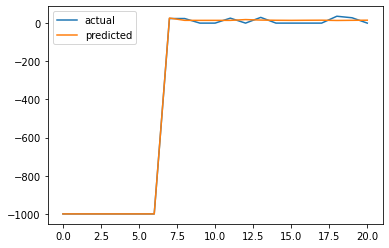

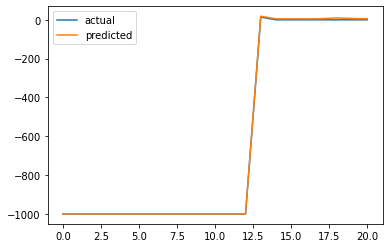

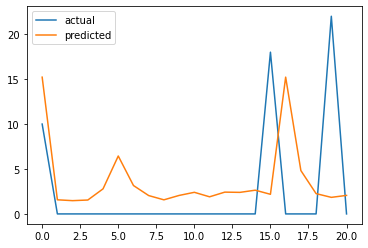

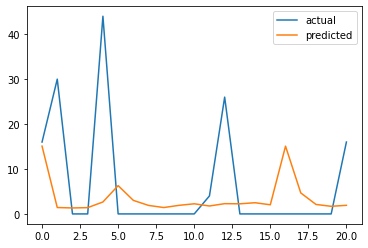

In [408]:
# extract the last predicted sequence
for seq in [-24, -36, -87, -103]:

    y_true = y[seq, :][-21:]
    y_pred = model.predict([X_encoder, X_decoder])[seq, :][-21:]

    # plot the last predicted sequence
    plt.plot(y_true.flatten(), label='actual')
    plt.plot(y_pred.flatten(), label='predicted')
    plt.legend()
    plt.show()

In [431]:
y_pred = model.predict([X_encoder_pred, X_decoder_pred])

In [498]:
y_pred[141][-21:]

array([[-999.9335   ],
       [-999.9538   ],
       [-999.9408   ],
       [-999.95404  ],
       [-999.95416  ],
       [-999.9541   ],
       [-999.9541   ],
       [-999.9541   ],
       [  -2.3633783],
       [  -2.4015312],
       [  -2.40442  ],
       [  -2.4071722],
       [  -2.3799295],
       [  -2.4229388],
       [  -2.3871193],
       [  -2.424222 ],
       [  -2.4134839],
       [  -2.41201  ],
       [  -2.3719888],
       [  -2.3917294],
       [  -2.4107258]], dtype=float32)

In [403]:
y[-1, :][-22:]

array([[-1000.],
       [   18.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.]])

In [205]:
X2 = []
y2 = []

for xx, yy in zip(X,y):
    X2.append(xx.T)
    y2.append(yy.T)
    
X2 = np.array(X2)
y2 = np.array(y2)

print(X2.shape)
print(y2.shape)

(36268, 60, 4)
(36268, 60, 1)


In [206]:
X_train, X_test = X2[:29014], X2[29014:]
y_train, y_test = y2[:29014], y2[29014:]

In [207]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [216]:
def init_model():
    metric = metrics.MAE
    opt = optimizers.RMSprop(learning_rate=0.01)
    
    #normalizer = Normalization()
    #normalizer.adapt(X_train)
    
    model = models.Sequential()
    model.add(layers.Masking(mask_value=-1000., input_shape=(60,4)))
    #model.add(normalizer)
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, return_sequences=True, activation='tanh'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse',
                  optimizer=opt,
                  metrics = [metric])
    
    return model

In [217]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_26 (Masking)        (None, 60, 4)             0         
                                                                 
 normalization_22 (Normaliza  (None, 60, 4)            9         
 tion)                                                           
                                                                 
 lstm_45 (LSTM)              (None, 60, 20)            2000      
                                                                 
 lstm_46 (LSTM)              (None, 60, 10)            1240      
                                                                 
 dense_55 (Dense)            (None, 60, 50)            550       
                                                                 
 dense_56 (Dense)            (None, 60, 10)            510       
                                                     

In [218]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=2, restore_best_weights=True)

model = init_model()

history = model.fit(X_train, y_train, epochs=3, validation_split=0.2, 
            batch_size=64,
            callbacks=[es], verbose=2)

Epoch 1/3
363/363 - 12s - loss: 24119.9844 - mean_absolute_error: 45.2602 - val_loss: 162.1123 - val_mean_absolute_error: 9.7059 - 12s/epoch - 34ms/step
Epoch 2/3
363/363 - 9s - loss: 1105.1848 - mean_absolute_error: 11.4878 - val_loss: 181.4655 - val_mean_absolute_error: 11.2093 - 9s/epoch - 24ms/step
Epoch 3/3
Restoring model weights from the end of the best epoch: 1.
363/363 - 9s - loss: 1166.8269 - mean_absolute_error: 10.8595 - val_loss: 434.6733 - val_mean_absolute_error: 16.4256 - 9s/epoch - 24ms/step
Epoch 3: early stopping


In [219]:
model.evaluate(X_test, y_test)

227/227 [==============================] - 1s 6ms/step - loss: 172.1444 - mean_absolute_error: 10.3812


[172.14443969726562, 10.381194114685059]

In [220]:
prediction = model.predict(X_test)

In [224]:
y_test[0]

array([[    2.],
       [   24.],
       [   16.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [   24.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [   20.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.

In [223]:
prediction[0]

array([[   1.637166 ],
       [   2.5607803],
       [   2.8002381],
       [   2.861462 ],
       [   2.9029677],
       [   2.926814 ],
       [   2.9526014],
       [   3.0281916],
       [   3.0470035],
       [   3.1738315],
       [   3.2406805],
       [   3.163703 ],
       [   3.122875 ],
       [   3.1297417],
       [   3.0497375],
       [   3.0244846],
       [   3.014164 ],
       [   3.0789998],
       [   3.0488122],
       [   3.0417457],
       [   3.0359643],
       [   3.3961957],
       [   3.5793905],
       [   3.276527 ],
       [   3.377349 ],
       [   3.4301891],
       [   3.6137505],
       [   3.259481 ],
       [-959.6419   ],
       [-986.57965  ],
       [-986.2376   ],
       [-983.0091   ],
       [-982.3925   ],
       [-984.5135   ],
       [-985.385    ],
       [-985.9052   ],
       [-986.1657   ],
       [-986.3189   ],
       [-986.419    ],
       [-986.4943   ],
       [-986.5567   ],
       [-986.6114   ],
       [-986.6608   ],
       [-98

In [49]:
history.history

{'loss': [34356968.0,
  24494996.0,
  16713496.0,
  15075442.0,
  15033100.0,
  15030301.0,
  15029687.0,
  15029394.0,
  15029253.0,
  15029116.0,
  15029027.0,
  15028953.0,
  15028918.0,
  15028885.0,
  15028829.0,
  15028805.0,
  15028790.0],
 'mean_squared_error': [34356968.0,
  24494996.0,
  16713496.0,
  15075442.0,
  15033100.0,
  15030301.0,
  15029687.0,
  15029394.0,
  15029253.0,
  15029116.0,
  15029027.0,
  15028953.0,
  15028918.0,
  15028885.0,
  15028829.0,
  15028805.0,
  15028790.0],
 'val_loss': [45338640.0,
  26658382.0,
  17907072.0,
  17456198.0,
  17448940.0,
  17440516.0,
  17439674.0,
  17450650.0,
  17441042.0,
  17441914.0,
  17440762.0,
  17439960.0,
  17440532.0,
  17440828.0,
  17439944.0,
  17439718.0,
  17440314.0],
 'val_mean_squared_error': [45338640.0,
  26658382.0,
  17907072.0,
  17456198.0,
  17448940.0,
  17440516.0,
  17439674.0,
  17450650.0,
  17441042.0,
  17441914.0,
  17440762.0,
  17439960.0,
  17440532.0,
  17440828.0,
  17439944.0,
  174

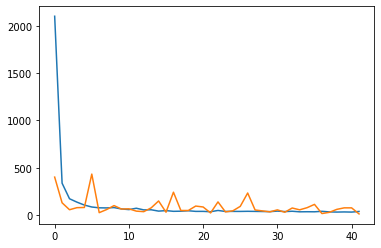

In [169]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [51]:
df = pd.read_csv('merged_treated.csv', index_col=[0])
df.head()

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,distance,points,Avg. speed winner:,Distance:,Parcours type:,ProfileScore:,Vert. meters:,Startlist quality score:,Won how:,adjusted_points
0,egan-bernal,2020,etappe,2020-09-16,0,NaN,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,0.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,0.0
1,andrey-amador,2020,etappe,2020-09-16,117,79.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,0.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,0.0
2,richard-carapaz,2020,etappe,2020-09-16,11,13.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,20.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,14962800.0
3,jonathan-castroviejo,2020,etappe,2020-09-16,116,40.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,0.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,0.0
4,michal-kwiatkowski,2020,etappe,2020-09-16,130,37.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,0.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,0.0


In [56]:
for i in df.name.unique()[:2]:
    print(i)

egan-bernal
andrey-amador


In [57]:
ls = []

for rider in df.name.unique()[:2]:
    ls.append(df_small[df_small['name']==rider])

In [ ]:
import numpy as np

def subsample_sequence(df, length):
        df_small[df_small['name']==rider]
        # $CHALLENGIFY_BEGIN
        last_possible = df.shape[0] - length - 5
        
        random_start = np.random.randint(0, last_possible)
        X = df[random_start: random_start+length].values
        y = df.iloc[random_start+length+1:random_start+length+21]['points']
        # $CHALLENGIFY_END
        return X, y

for rider in ls:
    X, y = subsample_sequence(rider, 365)

/var/folders/3l/70h6qcrd72q0j5x4sscw7qn40000gn/T/ipykernel_9756/69888416.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_small[df_small['name']==rider]


: 

: 

In [ ]:
X

array([[13.8, 0.0, 13.0, 28.0, 1812, 'daniele-bennati'],
       [13.8, 0.0, 13.0, 28.0, 1812, 'roman-kreuziger'],
       [13.8, 0.0, 13.0, 28.0, 1812, 'rafal-majka'],
       ...,
       [155.0, 0.0, 323.0, 4282.0, 1073, 'marcel-wyss'],
       [155.0, 0.0, 323.0, 4282.0, 1073, 'dominik-nerz'],
       [155.0, 0.0, 323.0, 4282.0, 1073, 'jan-barta']], dtype=object)